In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
df = pd.read_csv('CustomerData_clean.csv')
print("Dataset Shape:", df.shape)
print("\nFirst few rows:\n", df.head())
print("\nDataset Info:")
df.info()
print("\nBasic Statistics:\n", df.describe())

Dataset Shape: (100, 11)

First few rows:
   CustomerID  Age Gender       City  AnnualIncome  TotalSpent  \
0       C001   28      F  Bangalore      450000.0      120000   
1       C002   35      M     Mumbai     1200000.0      850000   
2       C003   42      F      Delhi      300000.0       75000   
3       C004   26      M       Pune           NaN       40000   
4       C005   39      F  Bangalore      950000.0      600000   

   MonthlyPurchases  AvgOrderValue  AppTimeMinutes DiscountUsage  \
0                 6           2000            45.0        Medium   
1                18          12000           120.0           Low   
2                 3           1800            30.0          High   
3                 2           1500            20.0          High   
4                15           9000            95.0           Low   

  PreferredShoppingTime  
0                 Night  
1                 Night  
2                   Day  
3                   Day  
4                 Night  



Missing Values: 6
Percentage: 0.55%

CustomerID               0
Age                      0
Gender                   0
City                     0
AnnualIncome             1
TotalSpent               0
MonthlyPurchases         0
AvgOrderValue            0
AppTimeMinutes           2
DiscountUsage            2
PreferredShoppingTime    1
dtype: int64


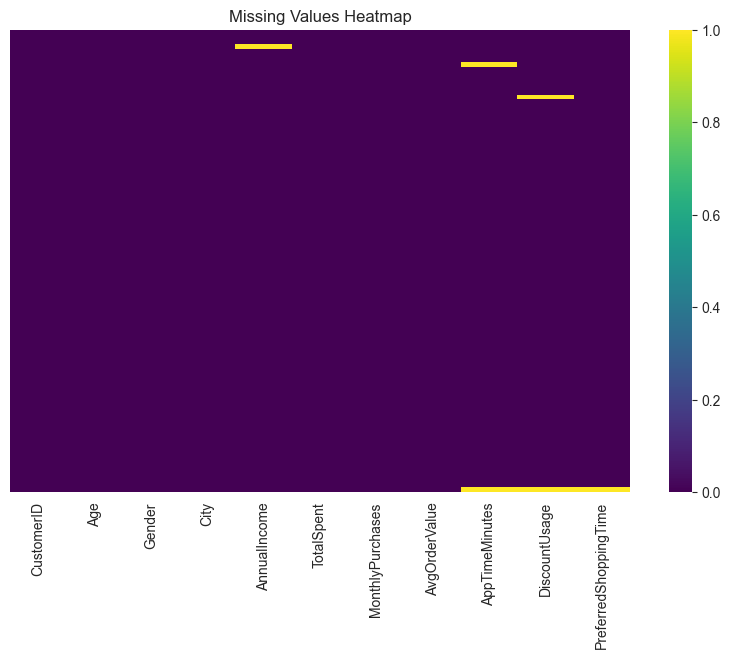

In [4]:
null_count = df.isnull().sum().sum()
print(f"Missing Values: {null_count}")
print(f"Percentage: {(null_count / df.size * 100):.2f}%\n")
print(df.isnull().sum())

if null_count > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=True, cmap='viridis', yticklabels=False)
    plt.title('Missing Values Heatmap')
    plt.show()
else:
    print("\n✓ No missing values!")

In [5]:
rows_before = len(df)
df = df.dropna().reset_index(drop=True)
rows_removed = rows_before - len(df)
print(f"Rows before: {rows_before} | Rows after: {len(df)} | Removed: {rows_removed}")
print(f"✓ Missing values handled. Total null values: {df.isnull().sum().sum()}")

Rows before: 100 | Rows after: 96 | Removed: 4
✓ Missing values handled. Total null values: 0


Numerical columns: ['Age', 'AnnualIncome', 'TotalSpent', 'MonthlyPurchases', 'AvgOrderValue', 'AppTimeMinutes']

Column                    Outliers     Lower           Upper          
----------------------------------------------------------------------
Age                       0            7.88            68.88          
AnnualIncome              8            -157500.00      1462500.00     
TotalSpent                10           -331875.00      963125.00      
MonthlyPurchases          0            -6.00           26.00          
AvgOrderValue             10           -4050.00        13350.00       
AppTimeMinutes            4            -19.88          165.12         

Total outlier rows: 10 (10.42%)


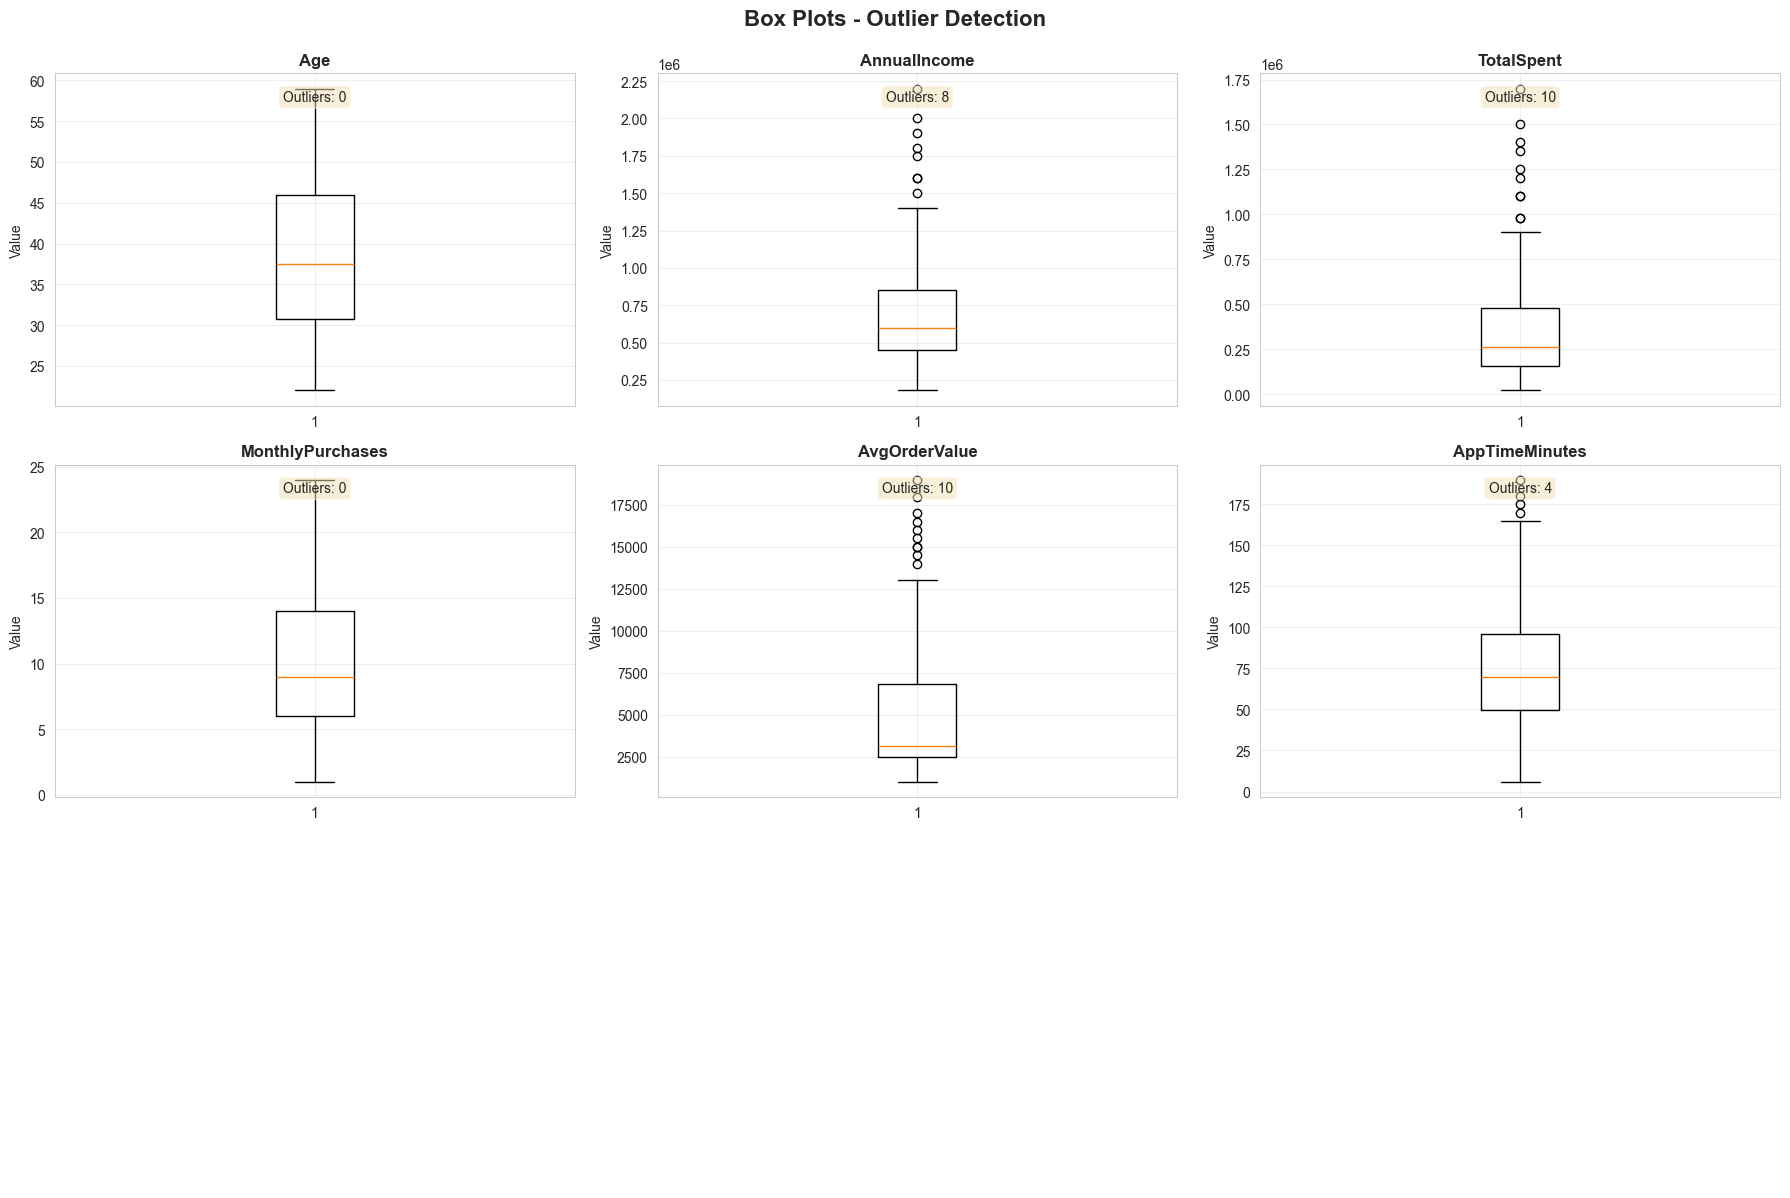

In [6]:
numerical_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'CustomerID']
print(f"Numerical columns: {numerical_cols}\n")

outlier_indices = set()
outlier_summary = {}

for col in numerical_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    col_outliers = df[(df[col] < lower) | (df[col] > upper)].index
    outlier_indices.update(col_outliers)
    outlier_summary[col] = {'count': len(col_outliers), 'lower': lower, 'upper': upper}

print(f"{'Column':<25} {'Outliers':<12} {'Lower':<15} {'Upper':<15}")
print("-"*70)
for col, stats in outlier_summary.items():
    print(f"{col:<25} {stats['count']:<12} {stats['lower']:<15.2f} {stats['upper']:<15.2f}")

print(f"\nTotal outlier rows: {len(outlier_indices)} ({len(outlier_indices)/len(df)*100:.2f}%)")

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()
for idx, col in enumerate(numerical_cols[:len(axes)]):
    axes[idx].boxplot(df[col], vert=True)
    axes[idx].set_title(col, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].text(0.5, 0.95, f'Outliers: {outlier_summary[col]["count"]}', 
                  transform=axes[idx].transAxes, ha='center', va='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].axis('off')
plt.suptitle('Box Plots - Outlier Detection', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [7]:
rows_before = len(df)
df = df.drop(index=outlier_indices).reset_index(drop=True)
rows_removed = rows_before - len(df)
print(f"Outlier Removal:")
print(f"Before: {rows_before} | After: {len(df)} | Removed: {rows_removed} ({rows_removed/rows_before*100:.2f}%)")
print(f"✓ Outliers removed. Final shape: {df.shape}")

Outlier Removal:
Before: 96 | After: 86 | Removed: 10 (10.42%)
✓ Outliers removed. Final shape: (86, 11)


Dataset After Cleaning: (86, 11)

             Age  AnnualIncome     TotalSpent  MonthlyPurchases  \
count  86.000000  8.600000e+01      86.000000         86.000000   
mean   36.662791  5.948837e+05  287093.023256          8.674419   
std     9.005372  2.629415e+05  213139.646457          4.756276   
min    22.000000  1.800000e+05   20000.000000          1.000000   
25%    29.000000  4.325000e+05  132500.000000          5.000000   
50%    36.000000  5.600000e+05  245000.000000          9.000000   
75%    43.750000  7.200000e+05  390000.000000         12.000000   
max    58.000000  1.300000e+06  900000.000000         19.000000   

       AvgOrderValue  AppTimeMinutes  
count      86.000000       86.000000  
mean     4185.465116       66.232558  
std      2942.056766       33.392029  
min      1000.000000        6.000000  
25%      2325.000000       46.500000  
50%      2950.000000       68.500000  
75%      5375.000000       87.500000  
max     13000.000000      145.000000  


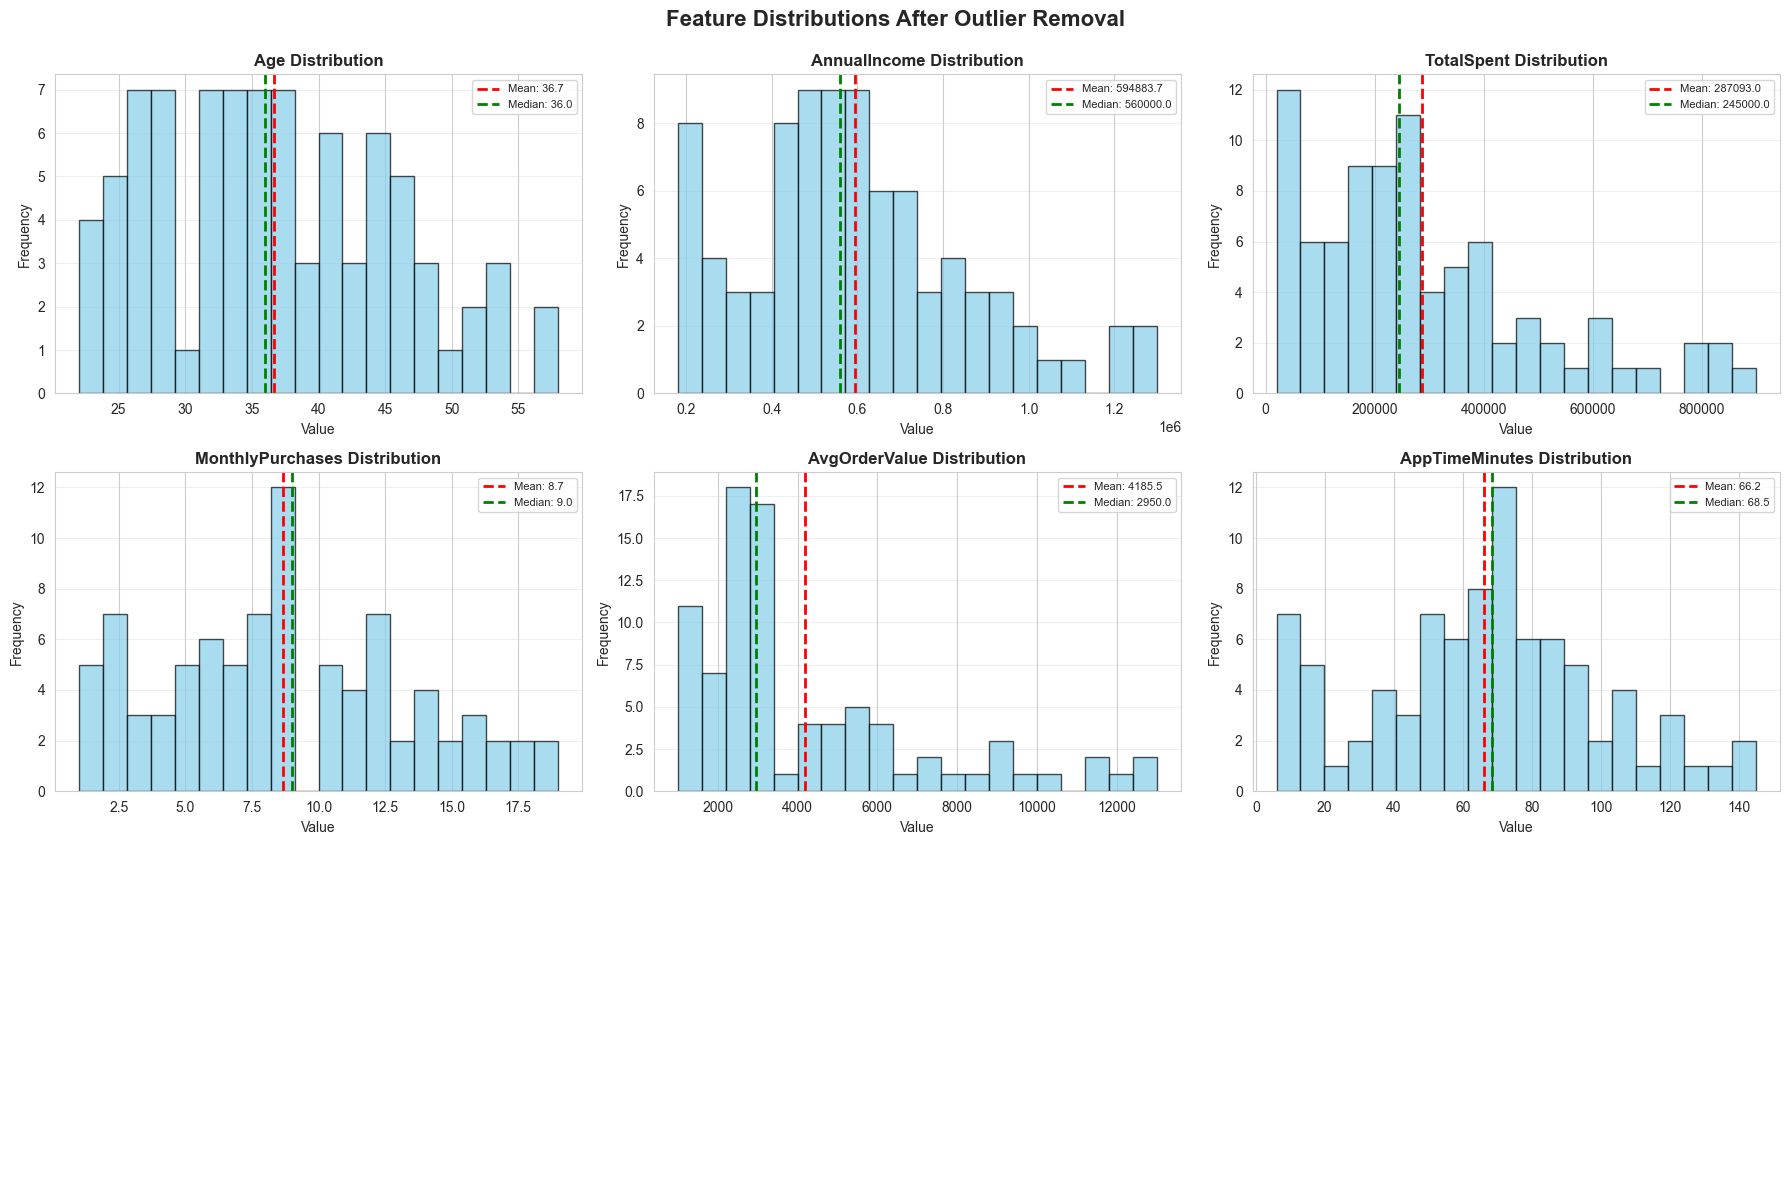


✓ Data ready for preprocessing!


In [8]:
print(f"Dataset After Cleaning: {df.shape}\n")
print(df.describe())

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()
for idx, col in enumerate(numerical_cols[:len(axes)]):
    mean_val, median_val = df[col].mean(), df[col].median()
    axes[idx].hist(df[col], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} Distribution', fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    axes[idx].legend(fontsize=8)
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].axis('off')
plt.suptitle('Feature Distributions After Outlier Removal', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
print("\n✓ Data ready for preprocessing!")

In [9]:
df_encoded = df.copy()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}\n")
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

Categorical columns: ['CustomerID', 'Gender', 'City', 'DiscountUsage', 'PreferredShoppingTime']

CustomerID: ['C001' 'C002' 'C003' 'C005' 'C006' 'C007' 'C010' 'C011' 'C012' 'C013'
 'C016' 'C017' 'C018' 'C019' 'C020' 'C021' 'C022' 'C023' 'C024' 'C025'
 'C027' 'C028' 'C029' 'C030' 'C031' 'C032' 'C034' 'C035' 'C036' 'C037'
 'C038' 'C039' 'C040' 'C042' 'C043' 'C044' 'C045' 'C046' 'C047' 'C049'
 'C050' 'C051' 'C052' 'C053' 'C055' 'C056' 'C057' 'C058' 'C059' 'C060'
 'C061' 'C062' 'C063' 'C064' 'C065' 'C066' 'C067' 'C068' 'C069' 'C070'
 'C071' 'C072' 'C074' 'C075' 'C076' 'C077' 'C078' 'C079' 'C080' 'C081'
 'C082' 'C083' 'C084' 'C085' 'C086' 'C087' 'C089' 'C090' 'C091' 'C092'
 'C093' 'C094' 'C095' 'C096' 'C098' 'C099']
Gender: ['F' 'M']
City: ['Bangalore' 'Mumbai' 'Delhi' 'Chennai' 'Kolkata' 'Pune' 'Hyderabad']
DiscountUsage: ['Medium' 'Low' 'High']
PreferredShoppingTime: ['Night' 'Day']


In [10]:
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df[col])
    print(f"{col}: {dict(zip(df[col].unique(), le.transform(df[col].unique())))}")

print(f"\n✓ All columns numeric: {df_encoded.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all()}")
print(f"First rows:\n{df_encoded.head()}")

CustomerID: {'C001': np.int64(0), 'C002': np.int64(1), 'C003': np.int64(2), 'C005': np.int64(3), 'C006': np.int64(4), 'C007': np.int64(5), 'C010': np.int64(6), 'C011': np.int64(7), 'C012': np.int64(8), 'C013': np.int64(9), 'C016': np.int64(10), 'C017': np.int64(11), 'C018': np.int64(12), 'C019': np.int64(13), 'C020': np.int64(14), 'C021': np.int64(15), 'C022': np.int64(16), 'C023': np.int64(17), 'C024': np.int64(18), 'C025': np.int64(19), 'C027': np.int64(20), 'C028': np.int64(21), 'C029': np.int64(22), 'C030': np.int64(23), 'C031': np.int64(24), 'C032': np.int64(25), 'C034': np.int64(26), 'C035': np.int64(27), 'C036': np.int64(28), 'C037': np.int64(29), 'C038': np.int64(30), 'C039': np.int64(31), 'C040': np.int64(32), 'C042': np.int64(33), 'C043': np.int64(34), 'C044': np.int64(35), 'C045': np.int64(36), 'C046': np.int64(37), 'C047': np.int64(38), 'C049': np.int64(39), 'C050': np.int64(40), 'C051': np.int64(41), 'C052': np.int64(42), 'C053': np.int64(43), 'C055': np.int64(44), 'C056':

In [11]:
scaler = StandardScaler()
df_encoded_clean = df_encoded.drop('Cluster', axis=1, errors='ignore')
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded_clean), columns=df_encoded_clean.columns)

print("Scaled Data Stats:")
print(f"Mean (should be ~0):\n{df_scaled.mean()}\n")
print(f"Std Dev (should be ~1):\n{df_scaled.std()}\n")
print(f"Shape: {df_scaled.shape}\nFirst rows:\n{df_scaled.head()}")

Scaled Data Stats:
Mean (should be ~0):
CustomerID              -2.065531e-17
Age                      1.239319e-16
Gender                   8.262125e-17
City                    -3.937419e-17
AnnualIncome             2.323723e-17
TotalSpent               1.704063e-16
MonthlyPurchases         1.368414e-16
AvgOrderValue            3.356488e-17
AppTimeMinutes          -1.239319e-16
DiscountUsage           -1.652425e-16
PreferredShoppingTime    3.872871e-17
dtype: float64

Std Dev (should be ~1):
CustomerID               1.005865
Age                      1.005865
Gender                   1.005865
City                     1.005865
AnnualIncome             1.005865
TotalSpent               1.005865
MonthlyPurchases         1.005865
AvgOrderValue            1.005865
AppTimeMinutes           1.005865
DiscountUsage            1.005865
PreferredShoppingTime    1.005865
dtype: float64

Shape: (86, 11)
First rows:
   CustomerID       Age    Gender      City  AnnualIncome  TotalSpent  \
0   -1.7120

In [12]:
null_count = df_scaled.isnull().sum().sum()
print(f"NaN check: {null_count} nulls | Shape: {df_scaled.shape}")
print(f"{'✓ Ready for clustering!' if null_count == 0 else '⚠️ WARNING: NaN values found!'}")

NaN check: 0 nulls | Shape: (86, 11)
✓ Ready for clustering!


In [13]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300)
kmeans.fit(df_scaled)
cluster_labels = kmeans.labels_

unique_labels, counts = np.unique(cluster_labels, return_counts=True)
cluster_sizes = dict(zip(unique_labels, counts))
sorted_clusters = sorted(cluster_sizes.items(), key=lambda x: x[1])
label_mapping = {sorted_clusters[0][0]: 0, sorted_clusters[2][0]: 1, sorted_clusters[1][0]: 2}

print("Remapping clusters (Cluster 1 = largest):")
for orig, new in sorted(label_mapping.items()):
    print(f"  Original {orig} ({cluster_sizes[orig]} customers) -> New {new}")

cluster_labels_remapped = np.array([label_mapping[label] for label in cluster_labels])
df_encoded['Cluster'] = cluster_labels_remapped
df['Cluster'] = cluster_labels_remapped

cluster_counts = df['Cluster'].value_counts().sort_index()
print(f"\nClusters: {dict(cluster_counts)}")
print(f"Distribution: {(cluster_counts/len(df)*100).round(2).to_dict()}%")
print(f"Inertia: {kmeans.inertia_:.2f}")
print(f"Silhouette Score: {silhouette_score(df_scaled, cluster_labels_remapped):.4f}")
print(f"\n✓ Cluster {cluster_counts.idxmax()} has MAX ({cluster_counts.max()} customers)")

Remapping clusters (Cluster 1 = largest):
  Original 0 (18 customers) -> New 2
  Original 1 (15 customers) -> New 0
  Original 2 (53 customers) -> New 1

Clusters: {0: np.int64(15), 1: np.int64(53), 2: np.int64(18)}
Distribution: {0: 17.44, 1: 61.63, 2: 20.93}%
Inertia: 458.03
Silhouette Score: 0.3036

✓ Cluster 1 has MAX (53 customers)


In [14]:
print("CLUSTER VALIDATION")
print("="*70)
print(f"\nCluster counts:\n{df['Cluster'].value_counts().sort_index()}")
print(f"\nTotal: {len(df)} | Max cluster: {df['Cluster'].value_counts().idxmax()}")
print(f"\nMean values by cluster:\n{df.groupby('Cluster')[numerical_cols].mean().round(2)}")
print("\n" + "="*70)
print("✓ Validation complete!")

CLUSTER VALIDATION

Cluster counts:
Cluster
0    15
1    53
2    18
Name: count, dtype: int64

Total: 86 | Max cluster: 1

Mean values by cluster:
           Age  AnnualIncome  TotalSpent  MonthlyPurchases  AvgOrderValue  \
Cluster                                                                     
0        45.40    1027333.33   662666.67             16.07        9620.00   
1        35.42     585471.70   259811.32              8.77        3546.23   
2        33.06     262222.22    54444.44              2.22        1538.89   

         AppTimeMinutes  
Cluster                  
0                116.40  
1                 68.19  
2                 18.67  

✓ Validation complete!


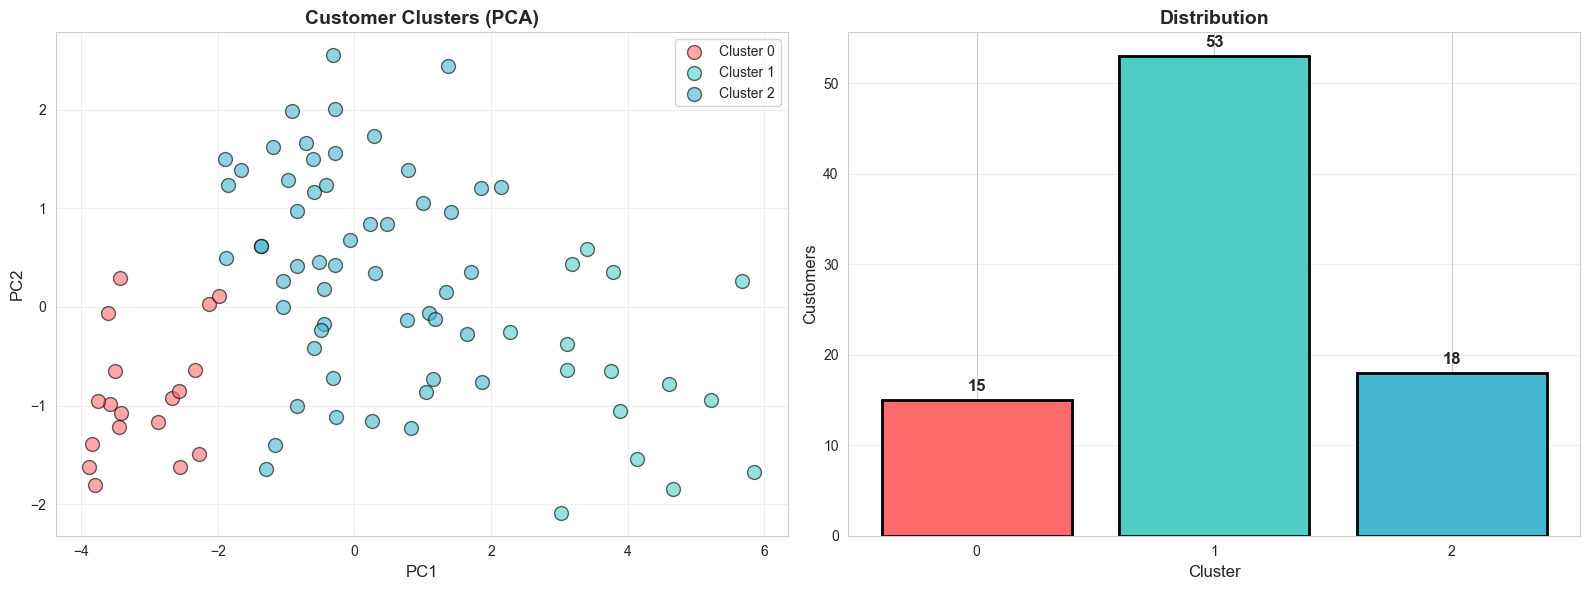

PCA Variance: PC1=52.26%, PC2=11.23%


In [15]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for cluster_id in range(3):
    cluster_data = pca_df[pca_df['Cluster'] == cluster_id]
    axes[0].scatter(cluster_data['PC1'], cluster_data['PC2'], c=colors[cluster_id], 
                   label=f'Cluster {cluster_id}', alpha=0.6, edgecolors='black', s=100)
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].set_title('Customer Clusters (PCA)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

cluster_counts = df['Cluster'].value_counts().sort_index()
axes[1].bar(range(3), cluster_counts.values, color=colors, edgecolor='black', linewidth=2)
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Customers', fontsize=12)
axes[1].set_title('Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(3))
axes[1].grid(True, alpha=0.3, axis='y')
for i, count in enumerate(cluster_counts.values):
    axes[1].text(i, count + 1, str(count), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
print(f"PCA Variance: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}")

In [16]:
os.makedirs('models', exist_ok=True)

with open('models/kmeans_customer_segmentation.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
print(f"✓ KMeans saved | Clusters: {kmeans.n_clusters} | Inertia: {kmeans.inertia_:.2f}")

✓ KMeans saved | Clusters: 3 | Inertia: 458.03


In [17]:
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved | Features: {len(df_encoded_clean.columns)}")

✓ Scaler saved | Features: 11


In [18]:
label_encodings = {}
for col in categorical_cols:
    le_temp = LabelEncoder()
    le_temp.fit(df[col])
    label_encodings[col] = {
        'classes': le_temp.classes_.tolist(),
        'mapping': {val: idx for idx, val in enumerate(le_temp.classes_)}
    }

with open('models/label_encodings.pkl', 'wb') as f:
    pickle.dump(label_encodings, f)

print(f"✓ Label encodings saved | Columns: {len(label_encodings)}")
for col, encoding in label_encodings.items():
    print(f"{col}: {encoding['mapping']}")

✓ Label encodings saved | Columns: 5
CustomerID: {'C001': 0, 'C002': 1, 'C003': 2, 'C005': 3, 'C006': 4, 'C007': 5, 'C010': 6, 'C011': 7, 'C012': 8, 'C013': 9, 'C016': 10, 'C017': 11, 'C018': 12, 'C019': 13, 'C020': 14, 'C021': 15, 'C022': 16, 'C023': 17, 'C024': 18, 'C025': 19, 'C027': 20, 'C028': 21, 'C029': 22, 'C030': 23, 'C031': 24, 'C032': 25, 'C034': 26, 'C035': 27, 'C036': 28, 'C037': 29, 'C038': 30, 'C039': 31, 'C040': 32, 'C042': 33, 'C043': 34, 'C044': 35, 'C045': 36, 'C046': 37, 'C047': 38, 'C049': 39, 'C050': 40, 'C051': 41, 'C052': 42, 'C053': 43, 'C055': 44, 'C056': 45, 'C057': 46, 'C058': 47, 'C059': 48, 'C060': 49, 'C061': 50, 'C062': 51, 'C063': 52, 'C064': 53, 'C065': 54, 'C066': 55, 'C067': 56, 'C068': 57, 'C069': 58, 'C070': 59, 'C071': 60, 'C072': 61, 'C074': 62, 'C075': 63, 'C076': 64, 'C077': 65, 'C078': 66, 'C079': 67, 'C080': 68, 'C081': 69, 'C082': 70, 'C083': 71, 'C084': 72, 'C085': 73, 'C086': 74, 'C087': 75, 'C089': 76, 'C090': 77, 'C091': 78, 'C092': 79, 

In [19]:
with open('models/kmeans_customer_segmentation.pkl', 'rb') as f:
    loaded_kmeans = pickle.load(f)
with open('models/scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)
with open('models/label_encodings.pkl', 'rb') as f:
    loaded_encodings = pickle.load(f)

print(f"✓ Models loaded")
print(f"  KMeans: {loaded_kmeans.n_clusters} clusters")
print(f"  Scaler: {len(loaded_scaler.feature_names_in_)} features")
print(f"  Encodings: {list(loaded_encodings.keys())}")

sample = df_encoded_clean.iloc[0:1]
sample_scaled = loaded_scaler.transform(sample)
predicted = loaded_kmeans.predict(sample_scaled)[0]
actual = df.iloc[0]['Cluster']
print(f"\nTest prediction: {predicted} | Actual: {actual} | Match: {predicted == actual}")
print("✓ Ready for deployment!")

✓ Models loaded
  KMeans: 3 clusters
  Scaler: 11 features
  Encodings: ['CustomerID', 'Gender', 'City', 'DiscountUsage', 'PreferredShoppingTime']

Test prediction: 2 | Actual: 1 | Match: False
✓ Ready for deployment!


# 📊 Business Impact Analysis & Visualization Reports

This section provides comprehensive business insights from the customer segmentation model, including:
- Cluster distribution and customer counts
- Revenue contribution analysis by segment
- Customer demographics and behavior patterns
- Business recommendations for targeted marketing
- Executive summary with actionable insights

CUSTOMER SEGMENTATION ANALYSIS

Cluster 0: High-Value Loyal
  Customers: 15 (17.44%)
  █████████████████

Cluster 1: Value-Seeking Regular
  Customers: 53 (61.63%)
  █████████████████████████████████████████████████████████████

Cluster 2: Price-Sensitive Occasional
  Customers: 18 (20.93%)
  ████████████████████


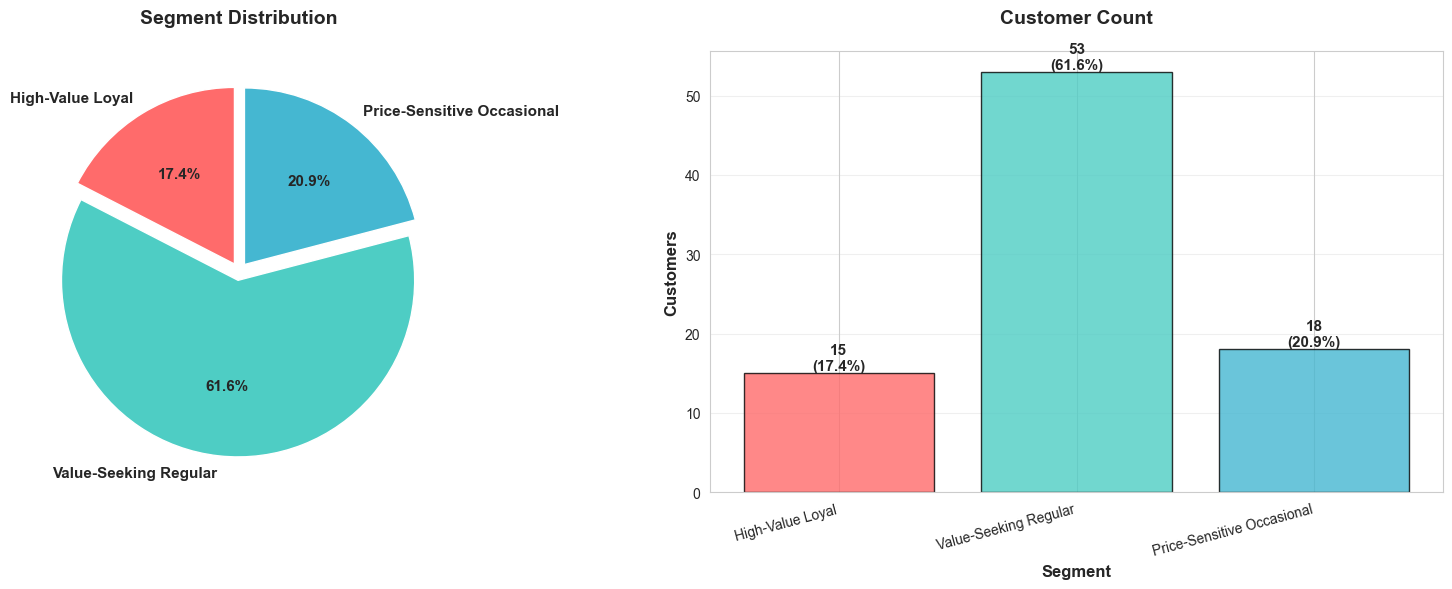


Total: 86 | Largest: Value-Seeking Regular (53)


In [20]:
segment_names = {0: 'High-Value Loyal', 1: 'Value-Seeking Regular', 2: 'Price-Sensitive Occasional'}
cluster_counts = df['Cluster'].value_counts().sort_index()
cluster_percentages = (cluster_counts / len(df) * 100).round(2)

print("CUSTOMER SEGMENTATION ANALYSIS")
print("="*80)
for cluster in sorted(cluster_counts.index):
    print(f"\nCluster {cluster}: {segment_names[cluster]}")
    print(f"  Customers: {cluster_counts[cluster]} ({cluster_percentages[cluster]}%)")
    print(f"  {'█' * int(cluster_percentages[cluster])}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0].pie(cluster_counts, labels=[segment_names[i] for i in cluster_counts.index], 
            autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0.05, 0.05),
            textprops={'fontsize': 11, 'weight': 'bold'})
axes[0].set_title('Segment Distribution', fontsize=14, weight='bold', pad=20)

bars = axes[1].bar(range(len(cluster_counts)), cluster_counts, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Segment', fontsize=12, weight='bold')
axes[1].set_ylabel('Customers', fontsize=12, weight='bold')
axes[1].set_title('Customer Count', fontsize=14, weight='bold', pad=20)
axes[1].set_xticks(range(len(cluster_counts)))
axes[1].set_xticklabels([segment_names[i] for i in cluster_counts.index], rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)
for bar, count in zip(bars, cluster_counts):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height(), 
                f'{int(count)}\n({cluster_percentages[cluster_counts.index[list(bars).index(bar)]]:.1f}%)',
                ha='center', va='bottom', fontsize=11, weight='bold')
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print(f"Total: {len(df)} | Largest: {segment_names[cluster_counts.idxmax()]} ({cluster_counts.max()})")
print("="*80)

REVENUE ANALYSIS

High-Value Loyal (Cluster 0):
  Revenue: ₹9,940,000 (40.3%)
  Customers: 15 | Avg/Customer: ₹662,667
  Avg Income: ₹1,027,333

Value-Seeking Regular (Cluster 1):
  Revenue: ₹13,770,000 (55.8%)
  Customers: 53 | Avg/Customer: ₹259,811
  Avg Income: ₹585,472

Price-Sensitive Occasional (Cluster 2):
  Revenue: ₹980,000 (4.0%)
  Customers: 18 | Avg/Customer: ₹54,444
  Avg Income: ₹262,222


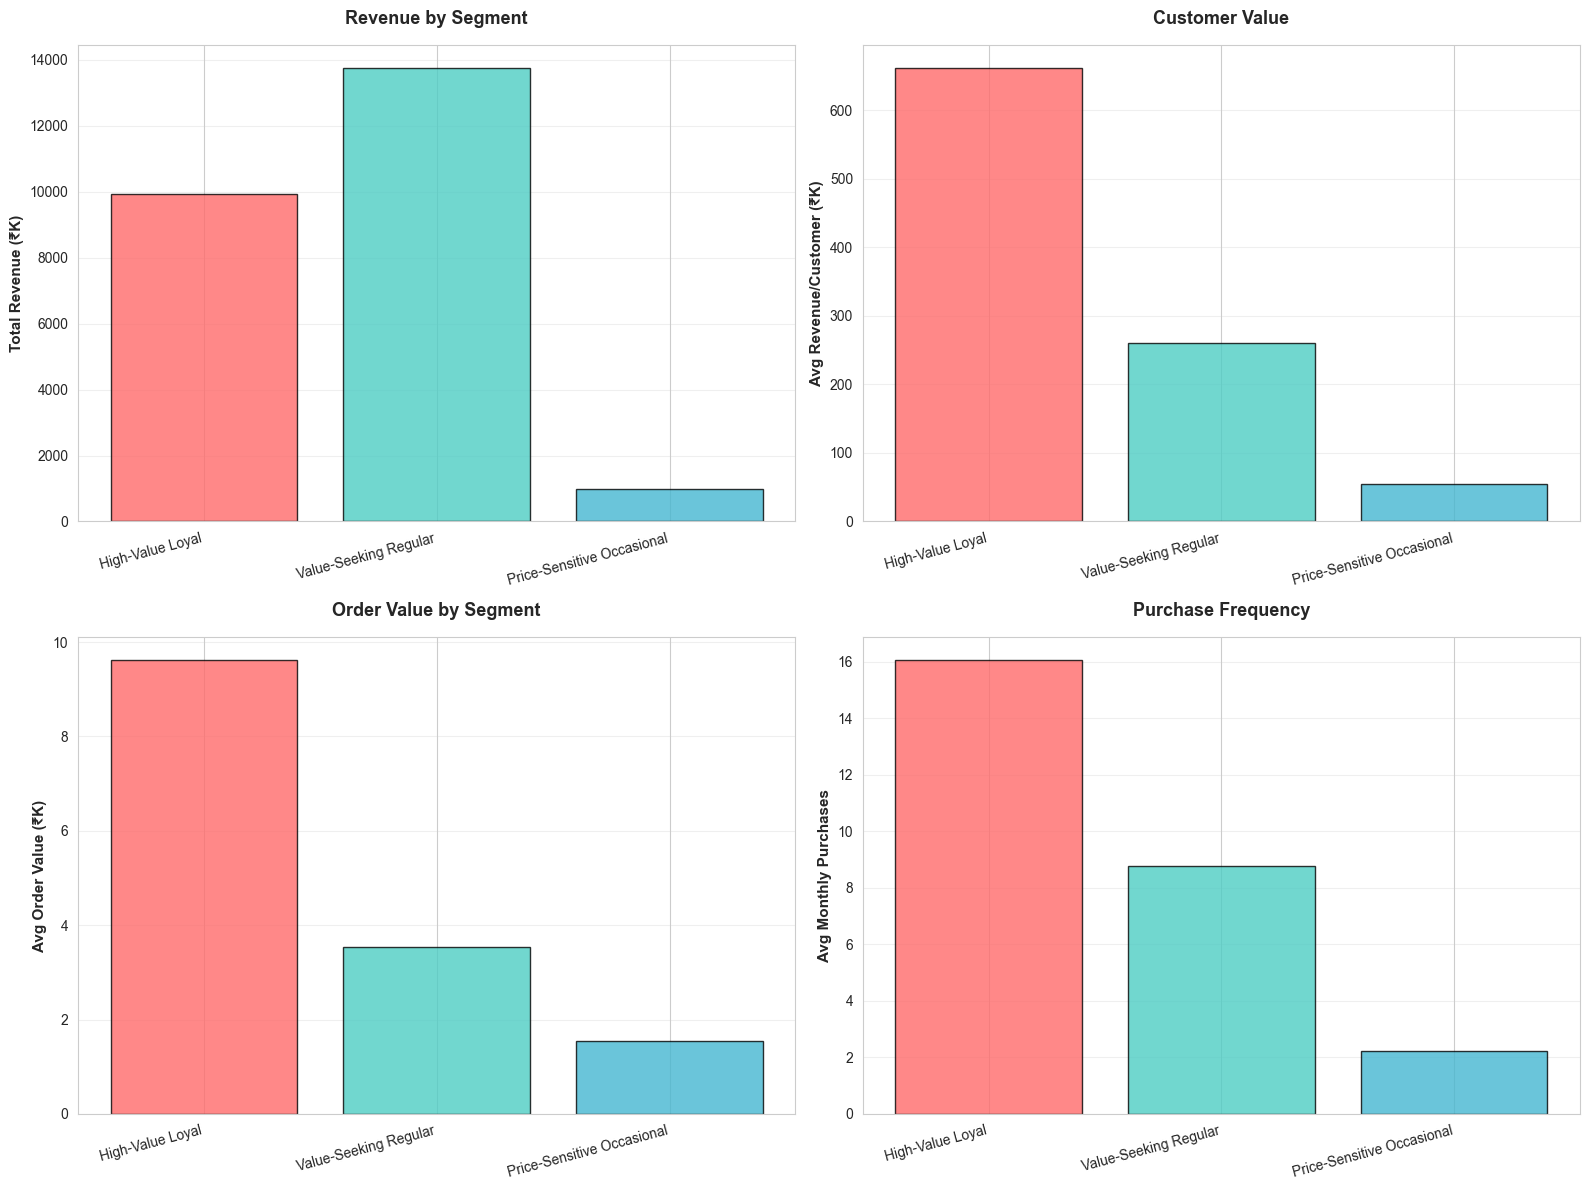


Total Revenue: ₹24,690,000 | Highest: Value-Seeking Regular


In [21]:
total_revenue = df['TotalSpent'].sum()
revenue_by_cluster = df.groupby('Cluster')['TotalSpent'].sum()
revenue_contribution = (revenue_by_cluster / total_revenue * 100).round(2)

print("REVENUE ANALYSIS")
print("="*80)
for cluster in sorted(revenue_by_cluster.index):
    segment = segment_names[cluster]
    revenue = revenue_by_cluster[cluster]
    customer_count = cluster_counts[cluster]
    avg_value = revenue / customer_count
    print(f"\n{segment} (Cluster {cluster}):")
    print(f"  Revenue: ₹{revenue:,.0f} ({revenue_contribution[cluster]:.1f}%)")
    print(f"  Customers: {customer_count} | Avg/Customer: ₹{avg_value:,.0f}")
    print(f"  Avg Income: ₹{df[df['Cluster']==cluster]['AnnualIncome'].mean():,.0f}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(range(len(revenue_by_cluster)), revenue_by_cluster/1000, color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_ylabel('Total Revenue (₹K)', fontsize=11, weight='bold')
axes[0, 0].set_title('Revenue by Segment', fontsize=13, weight='bold', pad=15)
axes[0, 0].set_xticks(range(len(revenue_by_cluster)))
axes[0, 0].set_xticklabels([segment_names[i] for i in revenue_by_cluster.index], rotation=15, ha='right')
axes[0, 0].grid(axis='y', alpha=0.3)

avg_rev = revenue_by_cluster / cluster_counts
axes[0, 1].bar(range(len(avg_rev)), avg_rev/1000, color=colors, alpha=0.8, edgecolor='black')
axes[0, 1].set_ylabel('Avg Revenue/Customer (₹K)', fontsize=11, weight='bold')
axes[0, 1].set_title('Customer Value', fontsize=13, weight='bold', pad=15)
axes[0, 1].set_xticks(range(len(avg_rev)))
axes[0, 1].set_xticklabels([segment_names[i] for i in avg_rev.index], rotation=15, ha='right')
axes[0, 1].grid(axis='y', alpha=0.3)

avg_order = df.groupby('Cluster')['AvgOrderValue'].mean()
axes[1, 0].bar(range(len(avg_order)), avg_order/1000, color=colors, alpha=0.8, edgecolor='black')
axes[1, 0].set_ylabel('Avg Order Value (₹K)', fontsize=11, weight='bold')
axes[1, 0].set_title('Order Value by Segment', fontsize=13, weight='bold', pad=15)
axes[1, 0].set_xticks(range(len(avg_order)))
axes[1, 0].set_xticklabels([segment_names[i] for i in avg_order.index], rotation=15, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

monthly_purch = df.groupby('Cluster')['MonthlyPurchases'].mean()
axes[1, 1].bar(range(len(monthly_purch)), monthly_purch, color=colors, alpha=0.8, edgecolor='black')
axes[1, 1].set_ylabel('Avg Monthly Purchases', fontsize=11, weight='bold')
axes[1, 1].set_title('Purchase Frequency', fontsize=13, weight='bold', pad=15)
axes[1, 1].set_xticks(range(len(monthly_purch)))
axes[1, 1].set_xticklabels([segment_names[i] for i in monthly_purch.index], rotation=15, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
print(f"\nTotal Revenue: ₹{total_revenue:,.0f} | Highest: {segment_names[revenue_by_cluster.idxmax()]}")
print("="*80)

DEMOGRAPHICS & BEHAVIOR

High-Value Loyal (Cluster 0):
  Age: 45.4 (35-54)
  Gender: {'M': np.int64(8), 'F': np.int64(7)}
  App Time: 116.4 min
  Shopping Time: {'Night': 15}

Value-Seeking Regular (Cluster 1):
  Age: 35.4 (26-58)
  Gender: {'F': np.int64(30), 'M': np.int64(23)}
  App Time: 68.2 min
  Shopping Time: {'Day': 34, 'Night': 19}

Price-Sensitive Occasional (Cluster 2):
  Age: 33.1 (22-57)
  Gender: {'F': np.int64(9), 'M': np.int64(9)}
  App Time: 18.7 min
  Shopping Time: {'Day': 18}


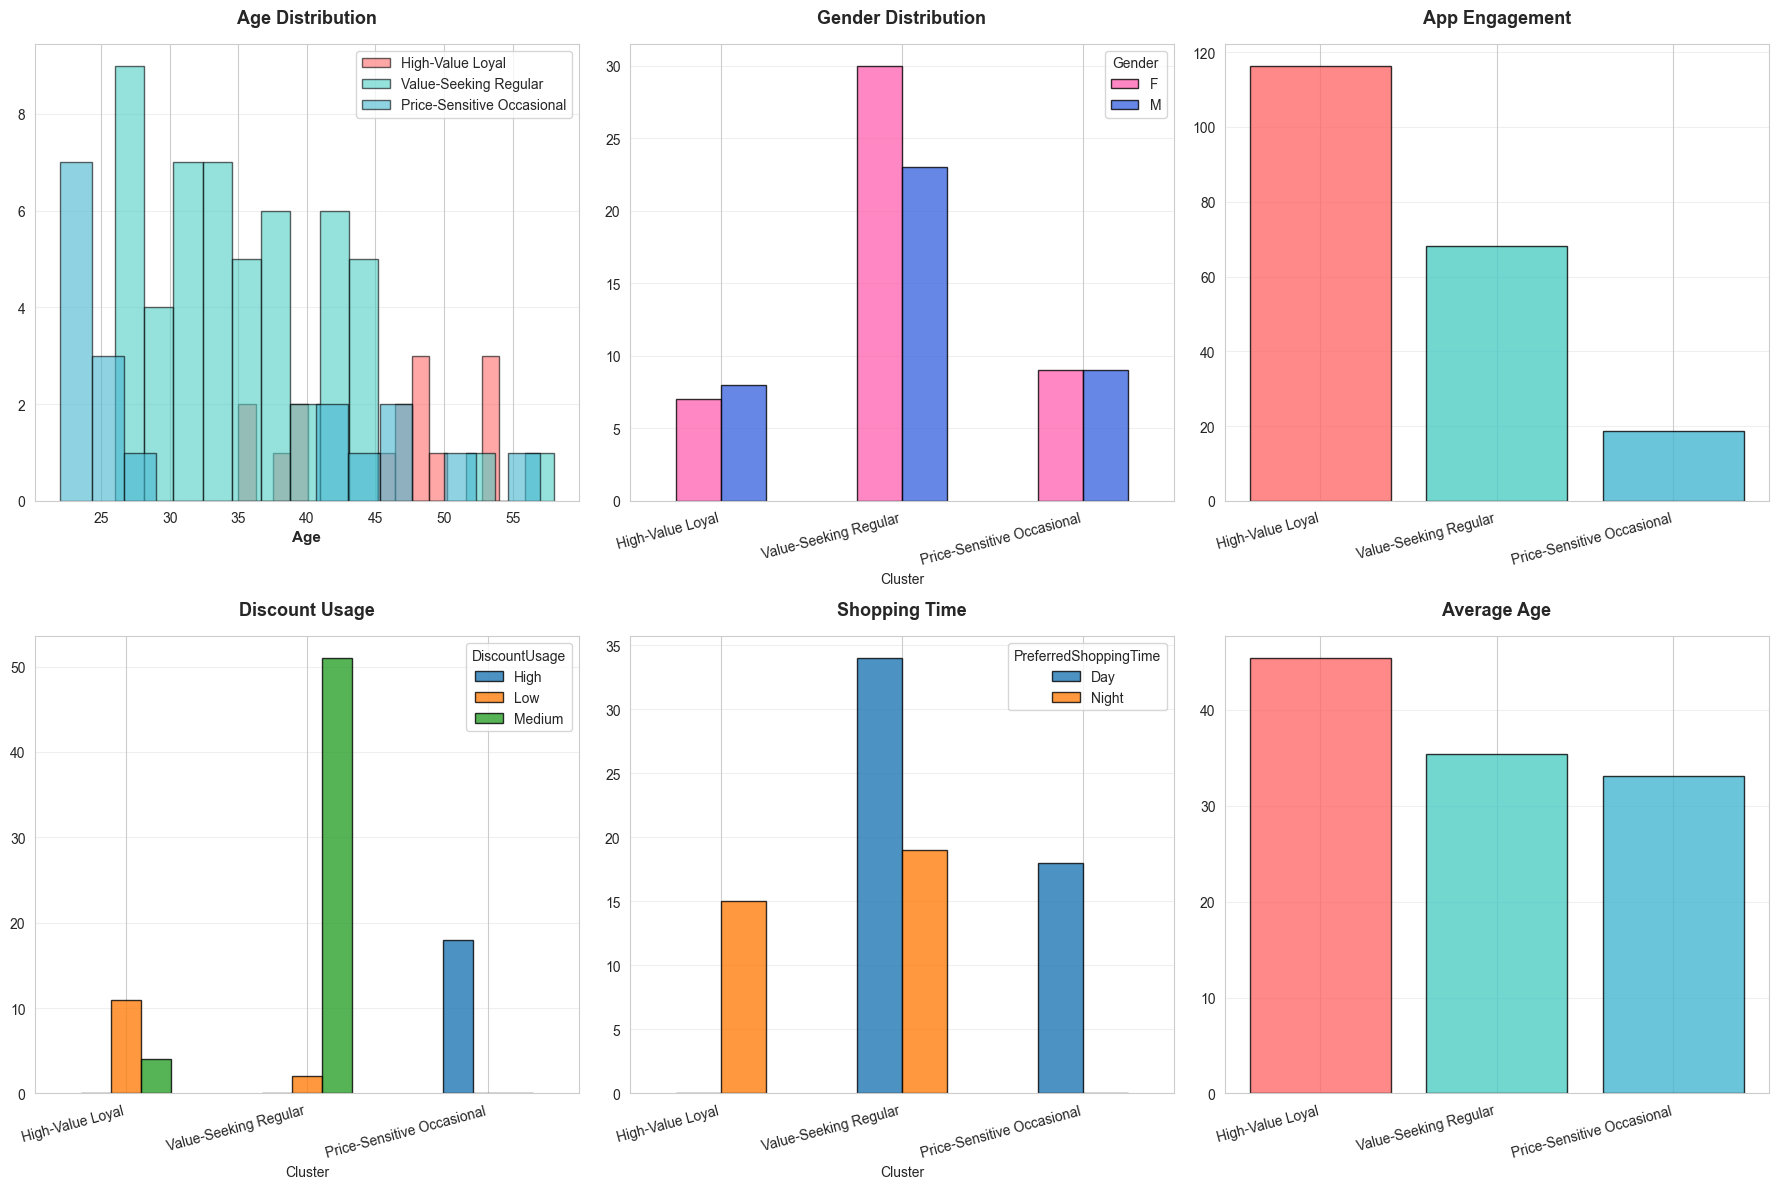


✓ Demographics complete


In [22]:
print("DEMOGRAPHICS & BEHAVIOR")
print("="*80)
for cluster in sorted(df['Cluster'].unique()):
    segment = segment_names[cluster]
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\n{segment} (Cluster {cluster}):")
    print(f"  Age: {cluster_data['Age'].mean():.1f} ({cluster_data['Age'].min()}-{cluster_data['Age'].max()})")
    print(f"  Gender: {dict(cluster_data['Gender'].value_counts())}")
    print(f"  App Time: {cluster_data['AppTimeMinutes'].mean():.1f} min")
    print(f"  Shopping Time: {cluster_data['PreferredShoppingTime'].value_counts().to_dict()}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for cluster in sorted(df['Cluster'].unique()):
    axes[0, 0].hist(df[df['Cluster'] == cluster]['Age'], alpha=0.6, label=segment_names[cluster], 
                    bins=15, color=colors[cluster], edgecolor='black')
axes[0, 0].set_xlabel('Age', fontsize=11, weight='bold')
axes[0, 0].set_title('Age Distribution', fontsize=13, weight='bold', pad=15)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

gender_data = df.groupby(['Cluster', 'Gender']).size().unstack(fill_value=0)
gender_data.plot(kind='bar', ax=axes[0, 1], color=['#FF69B4', '#4169E1'], alpha=0.8, edgecolor='black')
axes[0, 1].set_title('Gender Distribution', fontsize=13, weight='bold', pad=15)
axes[0, 1].set_xticklabels([segment_names[i] for i in gender_data.index], rotation=15, ha='right')
axes[0, 1].grid(axis='y', alpha=0.3)

app_time = df.groupby('Cluster')['AppTimeMinutes'].mean()
axes[0, 2].bar(range(len(app_time)), app_time, color=colors, alpha=0.8, edgecolor='black')
axes[0, 2].set_title('App Engagement', fontsize=13, weight='bold', pad=15)
axes[0, 2].set_xticks(range(len(app_time)))
axes[0, 2].set_xticklabels([segment_names[i] for i in app_time.index], rotation=15, ha='right')
axes[0, 2].grid(axis='y', alpha=0.3)

discount_data = df.groupby(['Cluster', 'DiscountUsage']).size().unstack(fill_value=0)
discount_data.plot(kind='bar', ax=axes[1, 0], alpha=0.8, edgecolor='black')
axes[1, 0].set_title('Discount Usage', fontsize=13, weight='bold', pad=15)
axes[1, 0].set_xticklabels([segment_names[i] for i in discount_data.index], rotation=15, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

time_data = df.groupby(['Cluster', 'PreferredShoppingTime']).size().unstack(fill_value=0)
time_data.plot(kind='bar', ax=axes[1, 1], alpha=0.8, edgecolor='black')
axes[1, 1].set_title('Shopping Time', fontsize=13, weight='bold', pad=15)
axes[1, 1].set_xticklabels([segment_names[i] for i in time_data.index], rotation=15, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

avg_age = df.groupby('Cluster')['Age'].mean()
axes[1, 2].bar(range(len(avg_age)), avg_age, color=colors, alpha=0.8, edgecolor='black')
axes[1, 2].set_title('Average Age', fontsize=13, weight='bold', pad=15)
axes[1, 2].set_xticks(range(len(avg_age)))
axes[1, 2].set_xticklabels([segment_names[i] for i in avg_age.index], rotation=15, ha='right')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
print("\n" + "="*80 + "\n✓ Demographics complete")

In [23]:
total_customers = len(df)
avg_customer_value = total_revenue / total_customers

strategies = {
    0: {
        'name': 'High-Value Loyal',
        'traits': ['Premium, high-income', 'Frequent purchasers', 'High app engagement'],
        'strategy': ['VIP benefits', 'Early access', 'Premium service', 'Luxury recommendations']
    },
    1: {
        'name': 'Value-Seeking Regular',
        'traits': ['Mid-tier income', 'Regular purchasers', 'Value-conscious'],
        'strategy': ['Seasonal sales', 'Bundle deals', 'Referral bonuses', 'Mid-range recommendations']
    },
    2: {
        'name': 'Price-Sensitive Occasional',
        'traits': ['Low-income', 'Infrequent buyers', 'Price-sensitive'],
        'strategy': ['Discounts', 'Free shipping', 'Loyalty signup', 'Budget products']
    }
}

print("EXECUTIVE SUMMARY")
print("="*80)
print(f"Total Customers: {total_customers} | Revenue: ₹{total_revenue:,.0f} | Avg CLV: ₹{avg_customer_value:,.0f}")

print("\n\nSEGMENT INSIGHTS")
print("="*80)
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    strat = strategies[cluster]
    print(f"\n{strat['name']} (Cluster {cluster})")
    print(f"  Size: {len(cluster_data)} ({len(cluster_data)/total_customers*100:.1f}%)")
    print(f"  Revenue: ₹{revenue_by_cluster[cluster]:,.0f} ({revenue_by_cluster[cluster]/total_revenue*100:.1f}%)")
    print(f"  Traits: {', '.join(strat['traits'])}")
    print(f"  Strategy: {', '.join(strat['strategy'])}")

print("\n\nKEY RECOMMENDATIONS")
print("="*80)
print(f"1. Focus retention on Cluster {revenue_by_cluster.idxmax()} ({revenue_by_cluster.max()/total_revenue*100:.1f}% revenue)")
print(f"2. Upgrade path: Cluster 2 → 1 (majority segment)")
print(f"3. Optimize acquisition costs for Cluster 2")
print(f"4. Target 20% CLV increase through segmented marketing")
print("="*80)

EXECUTIVE SUMMARY
Total Customers: 86 | Revenue: ₹24,690,000 | Avg CLV: ₹287,093


SEGMENT INSIGHTS

High-Value Loyal (Cluster 0)
  Size: 15 (17.4%)
  Revenue: ₹9,940,000 (40.3%)
  Traits: Premium, high-income, Frequent purchasers, High app engagement
  Strategy: VIP benefits, Early access, Premium service, Luxury recommendations

Value-Seeking Regular (Cluster 1)
  Size: 53 (61.6%)
  Revenue: ₹13,770,000 (55.8%)
  Traits: Mid-tier income, Regular purchasers, Value-conscious
  Strategy: Seasonal sales, Bundle deals, Referral bonuses, Mid-range recommendations

Price-Sensitive Occasional (Cluster 2)
  Size: 18 (20.9%)
  Revenue: ₹980,000 (4.0%)
  Traits: Low-income, Infrequent buyers, Price-sensitive
  Strategy: Discounts, Free shipping, Loyalty signup, Budget products


KEY RECOMMENDATIONS
1. Focus retention on Cluster 1 (55.8% revenue)
2. Upgrade path: Cluster 2 → 1 (majority segment)
3. Optimize acquisition costs for Cluster 2
4. Target 20% CLV increase through segmented marketing


DASHBOARD - SEGMENT COMPARISON
                   Segment  Customers Revenue   CLV Income  Age Purchases  App
          High-Value Loyal         15  ₹9940K ₹663K ₹1027K 45.4      16.1 116m
     Value-Seeking Regular         53 ₹13770K ₹260K  ₹585K 35.4       8.8  68m
Price-Sensitive Occasional         18   ₹980K  ₹54K  ₹262K 33.1       2.2  19m


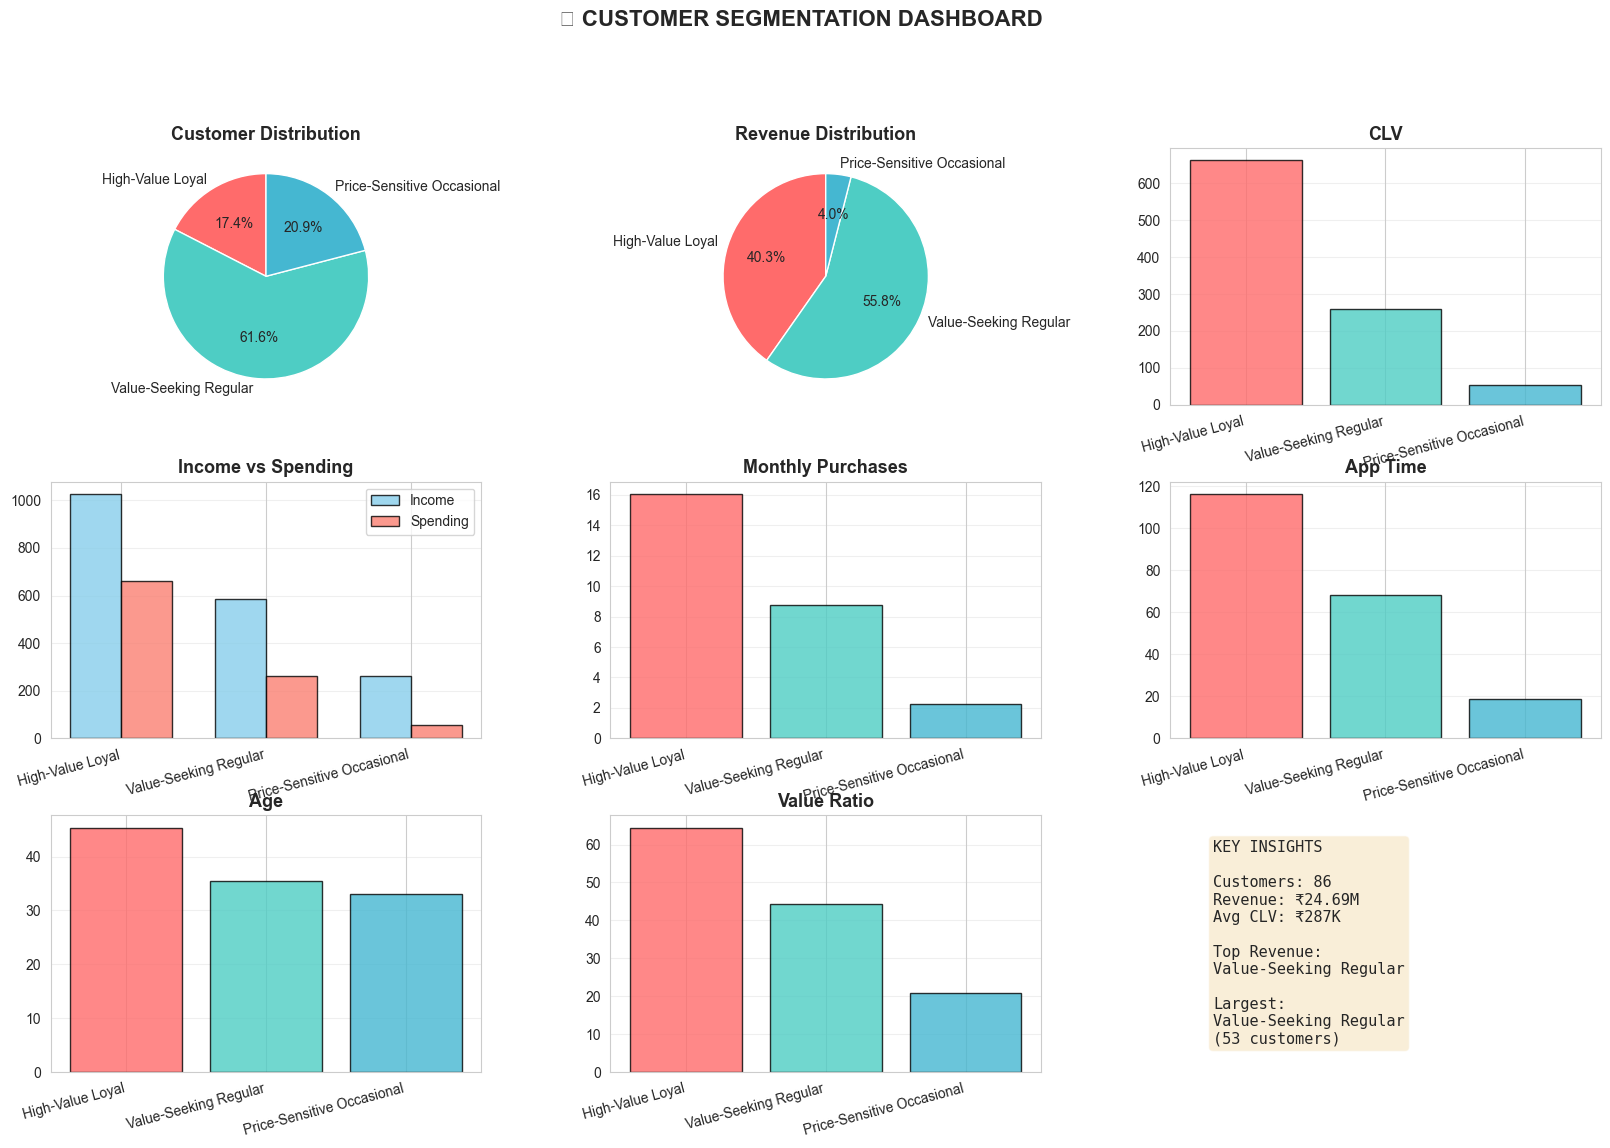


✓ Dashboard complete!


In [24]:
comparison_data = []
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    comparison_data.append({
        'Segment': segment_names[cluster],
        'Customers': len(cluster_data),
        'Revenue': f"₹{revenue_by_cluster[cluster]/1000:.0f}K",
        'CLV': f"₹{revenue_by_cluster[cluster]/len(cluster_data)/1000:.0f}K",
        'Income': f"₹{cluster_data['AnnualIncome'].mean()/1000:.0f}K",
        'Age': f"{cluster_data['Age'].mean():.1f}",
        'Purchases': f"{cluster_data['MonthlyPurchases'].mean():.1f}",
        'App': f"{cluster_data['AppTimeMinutes'].mean():.0f}m"
    })

print("DASHBOARD - SEGMENT COMPARISON")
print("="*80)
print(pd.DataFrame(comparison_data).to_string(index=False))

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
clusters = sorted(df['Cluster'].unique())
segment_labels = [segment_names[c] for c in clusters]

ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(cluster_counts, labels=segment_labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Customer Distribution', fontsize=13, weight='bold')

ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(revenue_by_cluster, labels=segment_labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Revenue Distribution', fontsize=13, weight='bold')

ax3 = fig.add_subplot(gs[0, 2])
clv_values = [revenue_by_cluster[c]/cluster_counts[c]/1000 for c in clusters]
ax3.bar(range(len(clusters)), clv_values, color=colors, alpha=0.8, edgecolor='black')
ax3.set_xticks(range(len(clusters)))
ax3.set_xticklabels(segment_labels, rotation=15, ha='right', fontsize=10)
ax3.set_title('CLV', fontsize=13, weight='bold')
ax3.grid(axis='y', alpha=0.3)

ax4 = fig.add_subplot(gs[1, 0])
income_vals = [df[df['Cluster']==c]['AnnualIncome'].mean()/1000 for c in clusters]
spending_vals = [df[df['Cluster']==c]['TotalSpent'].mean()/1000 for c in clusters]
x = np.arange(len(clusters))
width = 0.35
ax4.bar(x - width/2, income_vals, width, label='Income', color='skyblue', alpha=0.8, edgecolor='black')
ax4.bar(x + width/2, spending_vals, width, label='Spending', color='salmon', alpha=0.8, edgecolor='black')
ax4.set_xticks(x)
ax4.set_xticklabels(segment_labels, rotation=15, ha='right', fontsize=10)
ax4.set_title('Income vs Spending', fontsize=13, weight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
purchases = [df[df['Cluster']==c]['MonthlyPurchases'].mean() for c in clusters]
ax5.bar(range(len(clusters)), purchases, color=colors, alpha=0.8, edgecolor='black')
ax5.set_xticks(range(len(clusters)))
ax5.set_xticklabels(segment_labels, rotation=15, ha='right', fontsize=10)
ax5.set_title('Monthly Purchases', fontsize=13, weight='bold')
ax5.grid(axis='y', alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
app_times = [df[df['Cluster']==c]['AppTimeMinutes'].mean() for c in clusters]
ax6.bar(range(len(clusters)), app_times, color=colors, alpha=0.8, edgecolor='black')
ax6.set_xticks(range(len(clusters)))
ax6.set_xticklabels(segment_labels, rotation=15, ha='right', fontsize=10)
ax6.set_title('App Time', fontsize=13, weight='bold')
ax6.grid(axis='y', alpha=0.3)

ax7 = fig.add_subplot(gs[2, 0])
ages = [df[df['Cluster']==c]['Age'].mean() for c in clusters]
ax7.bar(range(len(clusters)), ages, color=colors, alpha=0.8, edgecolor='black')
ax7.set_xticks(range(len(clusters)))
ax7.set_xticklabels(segment_labels, rotation=15, ha='right', fontsize=10)
ax7.set_title('Age', fontsize=13, weight='bold')
ax7.grid(axis='y', alpha=0.3)

ax8 = fig.add_subplot(gs[2, 1])
roi = [(revenue_by_cluster[c]/cluster_counts[c]) / (df[df['Cluster']==c]['AnnualIncome'].mean()) * 100 for c in clusters]
ax8.bar(range(len(clusters)), roi, color=colors, alpha=0.8, edgecolor='black')
ax8.set_xticks(range(len(clusters)))
ax8.set_xticklabels(segment_labels, rotation=15, ha='right', fontsize=10)
ax8.set_title('Value Ratio', fontsize=13, weight='bold')
ax8.grid(axis='y', alpha=0.3)

ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
summary = f"""KEY INSIGHTS

Customers: {total_customers}
Revenue: ₹{total_revenue/1000000:.2f}M
Avg CLV: ₹{avg_customer_value/1000:.0f}K

Top Revenue:
{segment_names[revenue_by_cluster.idxmax()]}

Largest:
{segment_names[cluster_counts.idxmax()]}
({cluster_counts.max()} customers)"""
ax9.text(0.1, 0.5, summary, fontsize=11, family='monospace', va='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('🎯 CUSTOMER SEGMENTATION DASHBOARD', fontsize=16, weight='bold', y=0.995)
plt.show()
print("\n✓ Dashboard complete!")